# Benchmark the stability of signature network using the `CD_center_LM` signatures 

In [61]:
import os, sys, json
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance as dist
from sklearn import neighbors
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print nx.__version__

1.11


In [65]:
# Plot degree distribution
def plot_degree_distribution(G):
    fig, ax = plt.subplots()
    
    degrees = G.degree().values()
    degrees = dict(Counter(degrees))
    x = degrees.keys()
    y = degrees.values()

    ax.scatter(x, y, s=10, alpha=.6)
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)    
    ax.set_xscale('log')
    ax.set_yscale('log')
    return fig


In [4]:
## Load signature metadata mongodb
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000FWD']['sigs']
cur = coll.find({'SCS_centered_by_batch': {'$lt': 0.05}}, 
                {'_id':False, 
                 'sig_id':True, 
                 'SCS_centered_by_batch':True,
                 'pert_id':True,
                 'cell_id':True,
                 'pert_dose':True,
                })

sig_meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
sig_meta_df.rename(index=str,columns={'SCS_centered_by_batch':'pvalue'}, inplace=True)
print sig_meta_df.shape
sig_meta_df.head()

(48098, 4)


,pvalue,cell_id,pert_dose,pert_id
sig_id,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,0.0028,HS578T,2.0,BRD-K52911425
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,0.0483,HS578T,10.0,BRD-K69932463
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,0.0007,HS578T,10.0,BRD-K85606544
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,0.0000,HS578T,10.0,BRD-K72636697
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,0.0000,HS578T,0.4,BRD-K13390322


In [4]:
# sig_meta_df['batch'] = sig_meta_df.index.map(lambda x:x.split(':')[0])
# sig_meta_df['time'] = sig_meta_df['batch'].map(lambda x:x.split('_')[2].strip('H'))
# sig_meta_df.to_csv('../data/metadata-L1000FWD.tsv', sep='\t')

In [5]:
# Get the top 50 significant signatures for each pert_id
def pick_top_sigs(x):
    x = x.sort_values(ascending=True)
    n_significants = (x < 0.05).sum()
    if n_significants == 0:
        return x.head(0)
    else:
        n = min(50, n_significants)
        return x.head(n)

# grouped_sorted = sig_meta_df.groupby('pert_id')['pvalue'].apply(pick_top_sigs)

grouped_sorted = sig_meta_df.groupby('pert_id')['pvalue'].apply(lambda x: x.sort_values(ascending=True).head(20))

print grouped_sorted.shape
grouped_sorted.head()

(34502,)


pert_id        sig_id                                   
BRD-A00100033  CPC015_PHH_24H:BRD-A00100033-001-04-8:10     0.0203
BRD-A00267231  CPC001_PC3_6H:BRD-A00267231-001-01-1:10      0.0007
               CPC001_HA1E_24H:BRD-A00267231-001-01-1:10    0.0022
               CPC017_ASC_24H:BRD-A00267231-001-01-1:10     0.0126
               CPC017_A549_6H:BRD-A00267231-001-01-1:10     0.0228
Name: pvalue, dtype: float64

pert_id
BRD-K03109492    20
BRD-K64890080    20
BRD-K59962020    20
BRD-K59469039    20
BRD-A48237631    20
BRD-K59369769    20
BRD-K59184148    20
BRD-K58772419    20
BRD-A11678676    20
BRD-A49680073    20
Name: sig_id, dtype: int64


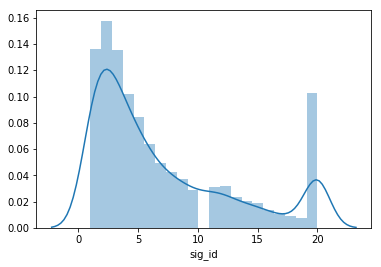

In [6]:
# filter out pert_id with less than 5 signatures
# pert_id_counts = sig_meta_df.reset_index().groupby('pert_id')['sig_id'].count()
pert_id_counts = grouped_sorted.reset_index().groupby('pert_id')['sig_id'].count()
print pert_id_counts.sort_values(ascending=False)[:10]
sns.distplot(pert_id_counts)

In [7]:
pert_ids_kept = pert_id_counts[pert_id_counts > 0].index.tolist()
# pert_ids_kept = pert_id_counts[pert_id_counts > 10].index.tolist()
print 'Number of pert_id to keep: %d' % len(pert_ids_kept)

Number of pert_id to keep: 4944


In [8]:
grouped_sorted = grouped_sorted[pert_ids_kept].reset_index()
print grouped_sorted.shape
n_sigs = grouped_sorted.shape[0]
print 'Number of sig_id to keep: %d' % n_sigs


(34502, 3)
Number of sig_id to keep: 34502


In [9]:
grouped_sorted.head()

,pert_id,sig_id,pvalue
0,BRD-A00100033,CPC015_PHH_24H:BRD-A00100033-001-04-8:10,0.0203
1,BRD-A00267231,CPC001_PC3_6H:BRD-A00267231-001-01-1:10,0.0007
2,BRD-A00267231,CPC001_HA1E_24H:BRD-A00267231-001-01-1:10,0.0022
3,BRD-A00267231,CPC017_ASC_24H:BRD-A00267231-001-01-1:10,0.0126
4,BRD-A00267231,CPC017_A549_6H:BRD-A00267231-001-01-1:10,0.0228


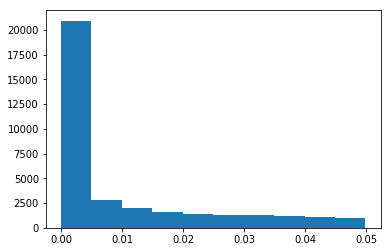

In [10]:
plt.hist(grouped_sorted['pvalue']);

In [11]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
        if i % 5000 == 0:
            print i, len(sig_ids)
    return sig_mat

In [12]:
## Extract signature matrix
mat = retrieve_sig_mat(grouped_sorted['sig_id'], coll, 'CD_center_LM')
print mat.shape

0 34502
5000 34502
10000 34502
15000 34502
20000 34502
25000 34502
30000 34502
(34502, 978)


In [13]:
def compute_adjcency_mat(X, metric='cosine'):
    adj_mat = dist.squareform(pairwise_distances(X, metric=metric))
    adj_mat = 1 - adj_mat
    
    
    # remove 1's on the diagnal
#     adj_mat -= np.eye(X.shape[0])
    ## convert negative values in adj_mat to 0's
    adj_mat[adj_mat<0] = 0
    return adj_mat

def create_graph_by_threshold(adj_mat, percentile):
#     triu_idx = np.tril_indices(adj_mat.shape[0], 1)
#     thresold = np.percentile(adj_mat[triu_idx], percentile)
    threshold = np.percentile(adj_mat, percentile)
    print threshold
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<threshold] = 0
    G = nx.from_numpy_matrix(dist.squareform(adj_mat_))
    return G

def create_graph_by_threshold2(adj_mat, cosine_cutoff):
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<cosine_cutoff] = 0
    G = nx.from_numpy_matrix(dist.squareform(adj_mat))
    return G
    

def create_knn_graph(X, k=30, metric='euclidean', n_jobs=1):
    '''Create a graph from a data matrix (sample x features).
    '''
    adj_mat = neighbors.kneighbors_graph(X, k, mode='connectivity', 
                                         metric=metric,
                                         n_jobs=n_jobs
                                        )
    G = nx.from_scipy_sparse_matrix(adj_mat)
    return G


In [14]:
def filter_out_small_ccs(G, cutoff=10):
    ## Create a new graph only keeping the large connected components
    G_new = nx.Graph()
    for cc in nx.connected_component_subgraphs(G):
        if cc.number_of_nodes() > cutoff:
            G_new = nx.compose(G_new, cc)
    return G_new

In [15]:
import scipy as sp
from scipy.sparse import linalg, csr_matrix

def compute_eigenvector_centrality(adj_mat):
    M = csr_matrix(dist.squareform(adj_mat))
    eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR')
    largest = eigenvector.flatten().real
    norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
    centrality = largest / norm
    return centrality


# Get adj_mat

In [16]:
## Compute adj_mat
adj_mat = compute_adjcency_mat(mat)
print adj_mat.shape

(595176751,)


In [30]:
## adj_mat with negative values preserved
adj_mat2 = dist.squareform(pairwise_distances(mat, metric='cosine'))
adj_mat2 = 1 - adj_mat2


## Compute node betweenness centrality for different thresholds

In [17]:
centrality_no_filt = compute_eigenvector_centrality(adj_mat)
print centrality_no_filt.shape

(34502,)


In [31]:
centrality_no_filt2 = compute_eigenvector_centrality(adj_mat2)
print centrality_no_filt2.shape

(34502,)


In [32]:
from scipy import stats

In [33]:
stats.pearsonr(centrality_no_filt, centrality_no_filt2)

(0.89098281599606777, 0.0)

In [34]:
for c in centralities:
    print stats.pearsonr(centrality_no_filt2, c)

(0.90090155507254244, 0.0)
(0.79261010764359385, 0.0)
(0.72260158344617509, 0.0)
(-0.2292999039460584, 0.0)
(0.89098281599606777, 0.0)


In [18]:
print adj_mat.min(), adj_mat.max()

0.0 0.949405926249


In [47]:
# percentiles = [10, 25, 50, 90, 95, 99, 99.5, 99.9]
percentiles = [95, 99, 99.5, 99.9, 99.95, 99.99]

centralities = []
for percentile in percentiles:
    threshold = np.percentile(adj_mat, percentile)
    print threshold
    adj_mat_ = adj_mat.copy()
    adj_mat_[adj_mat<threshold] = 0
    ## Keep nodes in the last graph to compute betweenness
#     adj_mat_ = dist.squareform(adj_mat_)[nodes_left_in_last_graph][:,nodes_left_in_last_graph]
#     print adj_mat_.shape
#     adj_mat_ = dist.squareform(adj_mat_)
    
    centrality = compute_eigenvector_centrality(adj_mat_)
    centralities.append(centrality)
    

0.0913876598522
0.157825108273
0.195626081551
0.304049656883
0.356740471553
0.480542387056


In [51]:
centralities.append(centrality_no_filt)
centralities_mat = np.array(centralities) # threshold x n_nodes matrix
print centralities_mat.shape

(7, 34502)


In [21]:
G = create_graph_by_threshold(adj_mat, percentiles[-1])
print G.number_of_nodes(), G.number_of_edges()
G = filter_out_small_ccs(G)
print G.number_of_nodes(), G.number_of_edges()

0.304049656883
34502 595177
16848 594372


In [22]:
nodes_left_in_last_graph = np.array(G.nodes())
print nodes_left_in_last_graph.shape

(16848,)


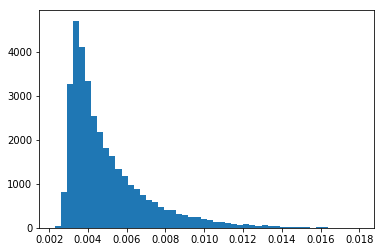

In [23]:
plt.hist(centrality_no_filt,bins=50);

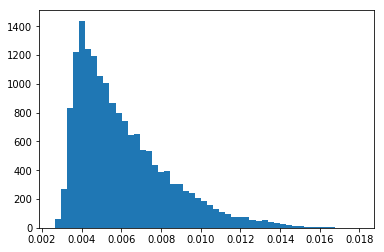

In [24]:
plt.hist(centrality_no_filt[nodes_left_in_last_graph],bins=50);

In [53]:
corrs = 1 - pairwise_distances(centralities_mat, metric='correlation')
print corrs.shape

(7, 7)


,95,99,99.5,99.9,99.95,99.99,full
95,1.000000,0.935845,0.873274,-0.037184,-0.034008,-0.023801,0.946208
99,0.935845,1.000000,0.985822,-0.037220,-0.034426,-0.025516,0.796548
99.5,0.873274,0.985822,1.000000,-0.031890,-0.029479,-0.021900,0.717620
99.9,-0.037184,-0.037220,-0.031890,1.000000,0.988266,0.848677,0.014017
99.95,-0.034008,-0.034426,-0.029479,0.988266,1.000000,0.903341,0.015636
99.99,-0.023801,-0.025516,-0.021900,0.848677,0.903341,1.000000,0.019193
full,0.946208,0.796548,0.717620,0.014017,0.015636,0.019193,1.000000


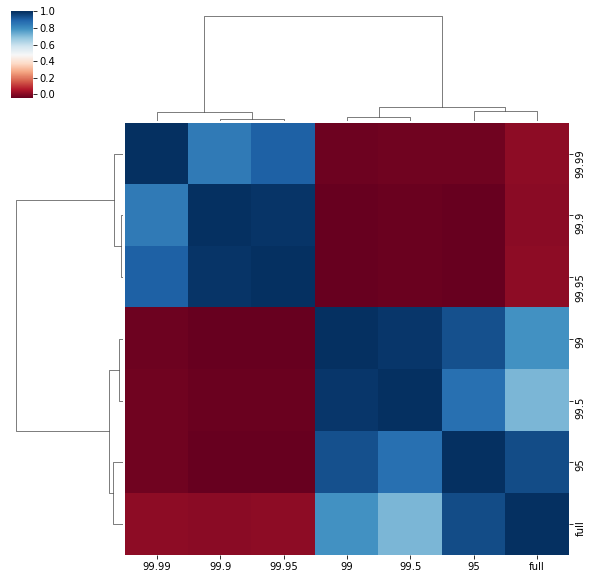

In [54]:
thresholds = percentiles + ['full']
corrs_df = pd.DataFrame(corrs, index=thresholds, columns=thresholds)
sns.clustermap(corrs_df, cmap='RdBu')
corrs_df

In [52]:
G = create_graph_by_threshold(adj_mat, 99)
print G.number_of_nodes(), G.number_of_edges()

0.157825108273
34502 5951768


In [53]:
G = filter_out_small_ccs(G)

In [55]:
print G.number_of_nodes(), G.number_of_edges()

34455 5951767


## Compute edge betweenness centrality

In [56]:
import cPickle as pickle

In [59]:
!mkdir -p edge_bc
!mkdir -p graphs

In [ ]:
for percentile in percentiles[::-1]:
    print percentile
    G = create_graph_by_threshold(adj_mat, percentile)
    print G.number_of_nodes(), G.number_of_edges() 
    G = filter_out_small_ccs(G)
    print G.number_of_nodes(), G.number_of_edges()
    plot_degree_distribution(G)
    pickle.dump(G, open('graphs/SignatureGraph_%s.pkl' % percentile, 'wb'))
    eb = nx.edge_betweenness_centrality(G, k=G.number_of_nodes()/1000, weight='weight')
    print len(eb)
    pickle.dump(eb, open('edge_bc/edge_betweenness_%s.pkl' % percentile, 'wb'))

99.99
0.480542387056
34502 59518
4831 58162
58162
99.95
0.356740471553
34502 297589
11810 296499
296499
99.9
0.304049656883
34502 595177
16848 594372
594372
99.5
0.195626081551
34502 2975884
32290 2975836
2975836
99
0.157825108273
34502 5951768
34455 5951767
5951767
95
0.0913876598522
34502 

In [62]:
!ls -lht edge_bc/

total 1.2G
-rw-r--r-- 1 root root 850M Oct 10 22:25 edge_betweenness_95.pkl
-rw-r--r-- 1 root root 174M Oct 10 17:02 edge_betweenness_99.pkl
-rw-r--r-- 1 root root  88M Oct 10 16:52 edge_betweenness_99.5.pkl
-rw-r--r-- 1 root root  18M Oct 10 16:47 edge_betweenness_99.9.pkl
-rw-r--r-- 1 root root 8.6M Oct 10 16:46 edge_betweenness_99.95.pkl
-rw-r--r-- 1 root root 1.7M Oct 10 16:46 edge_betweenness_99.99.pkl


In [63]:
!ls -lht graphs/

total 2.5G
-rw-r--r-- 1 root root 1.9G Oct 10 18:23 SignatureGraph_95.pkl
-rw-r--r-- 1 root root 368M Oct 10 16:55 SignatureGraph_99.pkl
-rw-r--r-- 1 root root 184M Oct 10 16:49 SignatureGraph_99.5.pkl
-rw-r--r-- 1 root root  37M Oct 10 16:47 SignatureGraph_99.9.pkl
-rw-r--r-- 1 root root  19M Oct 10 16:46 SignatureGraph_99.95.pkl
-rw-r--r-- 1 root root 3.6M Oct 10 16:46 SignatureGraph_99.99.pkl


95 34502 29758838
99 34455 5951767
99.5 32290 2975836
99.9 16848 594372
99.95 11810 296499
99.99 4831 58162


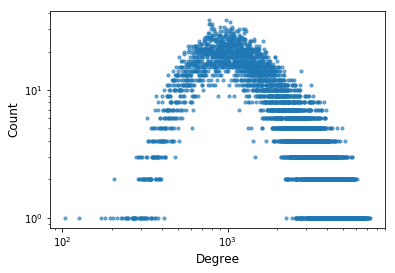

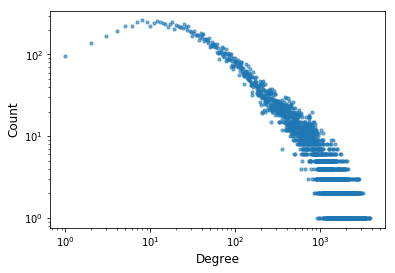

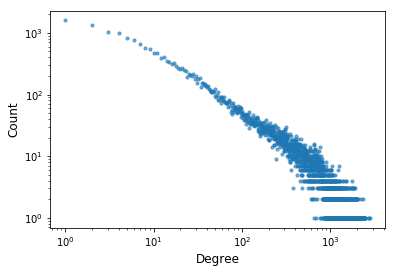

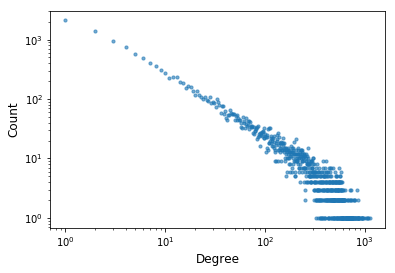

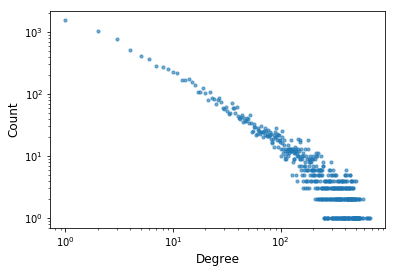

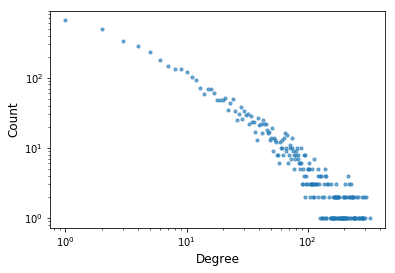

In [66]:
# Load graphs and plot degree distribution
for percentile in percentiles:
    G = pickle.load(open('graphs/SignatureGraph_%s.pkl' % percentile, 'rb'))
    print percentile, G.number_of_nodes(), G.number_of_edges()
    fig = plot_degree_distribution(G)
    fig.savefig('graphs/DigreeDistr_SignatureGraph_%s.pdf' % percentile)
    

In [95]:
# Load and gather edge betweenness 
G_smallest = pickle.load(open('graphs/SignatureGraph_%s.pkl' % percentiles[-1], 'rb'))
edges_shared = G_smallest.edges()
edges_shared = map(lambda e: tuple(sorted(e)),  edges_shared)
 
eb_mat = np.zeros((len(percentiles), len(edges_shared)))

def get_eb_val(eb, n1,n2):
    val = 0
    if (n1, n2) in eb:
        val = eb[(n1,n2)]
    elif (n2, n1) in eb:
        val = eb[(n2, n1)]
    return val

for i, percentile in enumerate(percentiles):
    eb = pickle.load(open('edge_bc/edge_betweenness_%s.pkl' % percentile, 'rb'))
    eb_mat[i] = [get_eb_val(eb, n1,n2) for n1, n2 in edges_shared]

    

print eb_mat.shape


(6, 58162)


In [97]:
for i in range(6):
    print eb_mat[i].sum()

0.0
0.0
0.0
2.70647096986e-05
5.25080649677e-05
0.00661840177288


In [92]:
print len(set(G.nodes())),  len(set(G_smallest.nodes()))
print len(set(G.nodes()) & set(G_smallest.nodes()))


34455 4831
4831


In [93]:
print len(set(G.edges())),  len(set(G_smallest.edges()))
print len(set(G.edges()) & set(G_smallest.edges()))


5951767 58162
35796


In [94]:
eb.items()[:10]

[((18720, 5146), 1.2856924289429937e-07),
 ((779, 4830), 0.0),
 ((24729, 10245), 0.0),
 ((3759, 5141), 0.0),
 ((29781, 30333), 0.0),
 ((26644, 28512), 0.0),
 ((16815, 3334), 0.0),
 ((9232, 1728), 0.0),
 ((8426, 17819), 0.0),
 ((10800, 29783), 0.0)]

In [98]:
# Compute correlation between edge betweenness across different percentile thresholds
eb_corrs = 1 - pairwise_distances(eb_mat, metric='correlation')
print eb_corrs.shape


(6, 6)


,95.0,99.0,99.5,99.9,99.95,99.99
95.00,1.0,0.0,0.0,0.000000,0.000000,0.000000
99.00,0.0,1.0,0.0,0.000000,0.000000,0.000000
99.50,0.0,0.0,1.0,0.000000,0.000000,0.000000
99.90,0.0,0.0,0.0,1.000000,0.012204,0.000195
99.95,0.0,0.0,0.0,0.012204,1.000000,0.004854
99.99,0.0,0.0,0.0,0.000195,0.004854,1.000000


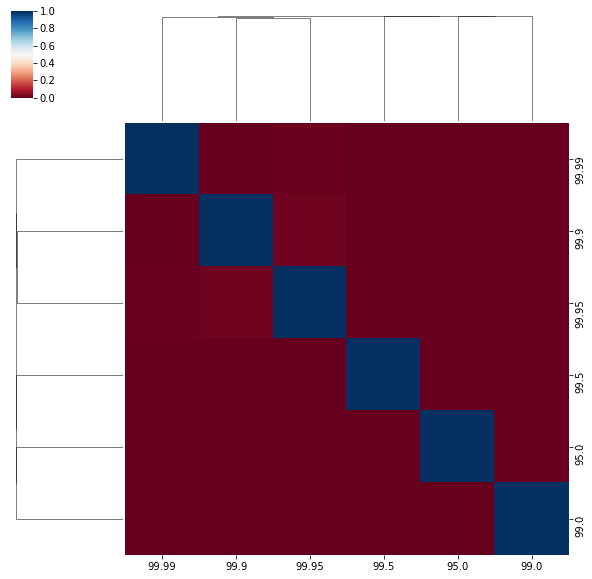

In [100]:
eb_corrs_df = pd.DataFrame(eb_corrs, index=percentiles, columns=percentiles).fillna(0)
sns.clustermap(eb_corrs_df, cmap='RdBu')
eb_corrs_df

In [66]:
print min(G.nodes()), max(G.nodes())

0 34501


In [68]:
# Make a matrix of edge betweenness
eb_mat = np.zeros((mat.shape[0], mat.shape[0]))
print eb_mat.shape
for (n1, n2), value in eb.items():
    eb_mat[n1,n2] = value
    eb_mat[n2,n1] = value
    
eb_mat = dist.squareform(eb_mat)
print eb_mat.shape

(34502, 34502)
(595176751,)


In [69]:
from scipy import stats

In [71]:
mask = eb_mat > 0
print stats.pearsonr(adj_mat[mask], eb_mat[mask])

(-0.013703012129681644, 6.7222287183404646e-31)


In [72]:
print eb_mat.min(), eb_mat.max()

0.0 1.8687360037e-05


In [73]:
G = create_graph_by_threshold(adj_mat, 99.5)
print G.number_of_nodes(), G.number_of_edges()

0.195626081551
34502 2975884


In [74]:
G = filter_out_small_ccs(G)
print G.number_of_nodes(), G.number_of_edges()

32290 2975836


In [75]:
eb995 = nx.edge_betweenness_centrality(G, k=G.number_of_nodes()/1000, weight='weight')
print len(eb995)

2975836


In [76]:
# Make a matrix of edge betweenness
eb_mat995 = np.zeros((mat.shape[0], mat.shape[0]))
print eb_mat995.shape
for (n1, n2), value in eb995.items():
    eb_mat995[n1,n2] = value
    eb_mat995[n2,n1] = value
    
eb_mat995 = dist.squareform(eb_mat995)
print eb_mat995.shape

(34502, 34502)
(595176751,)


In [77]:
stats.pearsonr(eb_mat995, eb_mat)

(0.0002708233425066185, 3.9199379196460237e-11)

In [78]:
M = nx.to_scipy_sparse_matrix(G, nodelist=G.nodes(), weight='weight', dtype=float)
print M.shape

(32290, 32290)


In [84]:
type(M)

scipy.sparse.csr.csr_matrix

In [79]:
from scipy.sparse import linalg
eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which='LR')

In [81]:
import scipy as sp
largest = eigenvector.flatten().real
norm = sp.sign(largest.sum())*sp.linalg.norm(largest)
print largest.shape, norm.shape

(32290,) ()


In [83]:
centrality = largest / norm
print centrality.shape

(32290,)


In [46]:
G_r = nx.fast_gnp_random_graph(200, 5./200)
print G_r.number_of_nodes(), G_r.number_of_edges()


200 475


In [48]:
eb = nx.edge_betweenness_centrality(G_r, k=G_r.number_of_nodes()/20, weight='weight')

In [50]:
eb.items()[:5]

[((49, 78), 0.0002561717316742443),
 ((105, 151), 0.00028661104000115233),
 ((162, 182), 0.00011165948791576935),
 ((16, 88), 7.380653266331659e-05),
 ((96, 130), 0.00020355746988912814)]

# Test the run-time for computing betweenness

In [56]:
n = 2000
G_r = nx.fast_gnp_random_graph(n, 5./n)
print G_r.number_of_nodes(), G_r.number_of_edges()


2000 5049


In [57]:
for sub_G in nx.connected_component_subgraphs(G_r):
    print sub_G.number_of_nodes(), sub_G.number_of_edges()

1984 5049
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


In [58]:
sub_G = next(nx.connected_component_subgraphs(G_r))
print sub_G.number_of_nodes(), sub_G.number_of_edges()

1984 5049


In [20]:
%%timeit
bc = nx.betweenness_centrality(G, k=n)

1 loop, best of 3: 11 s per loop


In [21]:
%%timeit
bc = nx.betweenness_centrality(G, k=n/2)

1 loop, best of 3: 5.43 s per loop


In [22]:
%%timeit
bc = nx.betweenness_centrality(G, k=n/4)

1 loop, best of 3: 2.71 s per loop


In [23]:
%%timeit
bc = nx.betweenness_centrality(G, k=n/8)

1 loop, best of 3: 1.32 s per loop


In [29]:
%%timeit
bc = nx.approximate_current_flow_betweenness_centrality(sub_G, solver='full',
                                                        epsilon=0.5, 
                                                        kmax=n/8)

1 loop, best of 3: 1.99 s per loop


In [30]:
%%timeit
bc = nx.approximate_current_flow_betweenness_centrality(sub_G, solver='lu',
                                                        epsilon=0.5, 
                                                        kmax=n/8)

1 loop, best of 3: 1.52 s per loop


In [32]:
%%timeit
bc = nx.approximate_current_flow_betweenness_centrality(sub_G, solver='lu',
                                                        epsilon=1, 
                                                        kmax=n/8)

1 loop, best of 3: 1.03 s per loop


In [33]:
%%timeit
bc = nx.communicability_centrality(sub_G)

1 loop, best of 3: 1.75 s per loop


In [34]:
%%timeit
bc = nx.eigenvector_centrality(sub_G, tol=1e-6)

1 loop, best of 3: 154 ms per loop


In [35]:
%%timeit
bc = nx.eigenvector_centrality(sub_G, tol=1e-5)

10 loops, best of 3: 110 ms per loop


In [36]:
%%timeit
bc = nx.eigenvector_centrality_numpy(sub_G)

10 loops, best of 3: 26.8 ms per loop


In [37]:
%%timeit
bc = nx.katz_centrality(sub_G)

1 loop, best of 3: 163 ms per loop


In [38]:
%%timeit
bc = nx.katz_centrality(sub_G, tol=1e-5)

10 loops, best of 3: 136 ms per loop


In [39]:
%%timeit
bc = nx.katz_centrality_numpy(sub_G)

10 loops, best of 3: 134 ms per loop


## Time it on a larger network

In [4]:
n = 20000
G = nx.fast_gnp_random_graph(n, 15./n)
print G.number_of_nodes(), G.number_of_edges()
sub_G = next(nx.connected_component_subgraphs(G))
print sub_G.number_of_nodes(), sub_G.number_of_edges()

20000 149620
20000 149620


In [5]:
%%timeit
bc = nx.eigenvector_centrality_numpy(sub_G)

1 loop, best of 3: 386 ms per loop


In [ ]:
%%timeit
# bc = nx.approximate_current_flow_betweenness_centrality(sub_G, solver='lu',
#                                                         epsilon=1, 
#                                                         kmax=n/200)

# Shortest path length/ edge betweenness

In [7]:
%%timeit
# sp = nx.shortest_path_length(G)

The slowest run took 200.75 times longer than the fastest. This could mean that an intermediate result is being cached.
100000000 loops, best of 3: 7.53 ns per loop


In [9]:
%%timeit
# sp = nx.all_pairs_dijkstra_path_length(G, cutoff=None)

1 loop, best of 3: 17 s per loop


In [10]:
%%timeit
# sp = nx.all_pairs_dijkstra_path_length(G, cutoff=6)

1 loop, best of 3: 16.8 s per loop


In [15]:
%%timeit
# sp = nx.edge_betweenness_centrality(sub_G, k=n/20)

1 loop, best of 3: 657 ms per loop


In [59]:
%%timeit
sp = nx.edge_betweenness_centrality(sub_G, k=n/200)

10 loops, best of 3: 70.7 ms per loop


In [62]:
from itertools import combinations
def pseudoinverse_laplacian(G):
    L = nx.laplacian_matrix(G)
    L = L.todense()
    L_plus = np.linalg.pinv(L)
    Vg = np.diag(L).sum()
    return L_plus, L, Vg

def mean_CT(L_plus, L, Vg, i, j):
    ## average commute time
    ## i, j are indices of two nodes
    CT_ij = Vg * (L_plus[i,i] + L_plus[j,j]- 2*L_plus[i,j])
    return CT_ij

def compute_mean_CT_matrix(G):
    L_plus, L, Vg = pseudoinverse_laplacian(G)
    c = 1
    nodes = G.nodes()
    num_nodes = len(nodes)
    
    d = {}
    for i, j in combinations(xrange(num_nodes), 2):	
        c += 1
        ct = mean_CT(L_plus, L, Vg, i, j)
        edge = (i, j)
#         if c % 50000 == 0:
#             print 'Finished', c, total
        d[edge] = ct
    return d


In [63]:
%%timeit
sp = compute_mean_CT_matrix(sub_G)

1 loop, best of 3: 14.8 s per loop


In [64]:
%%timeit
_ = pseudoinverse_laplacian(sub_G)

1 loop, best of 3: 3.74 s per loop


In [ ]:
sub_G.number_of_nodes()

In [11]:
bc = nx.eigenvector_centrality_numpy(sub_G)
print sub_G.number_of_nodes(), sub_G.number_of_edges()
print len(bc)

1989 5161
1989


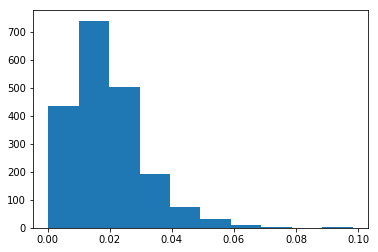

In [13]:
plt.hist(bc.values());

In [16]:
# Compute the pairwise cosine distance and convert to adjacency matrix
adj_mat = compute_adjcency_mat(mat)
print adj_mat.shape

(84988, 84988)


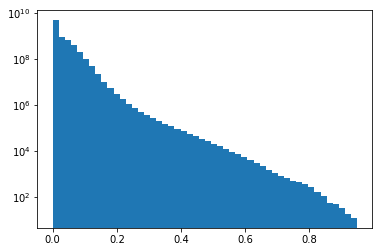

In [17]:
plt.hist(adj_mat.ravel(), bins=50, log=True);

In [ ]:
# Create network by applying threshold 
# G = create_graph_by_threshold(adj_mat, 99.92)
# G = create_graph_by_threshold2(adj_mat, 0.4)
# G = create_graph_by_threshold2(adj_mat, 0.3)
G = create_graph_by_threshold2(adj_mat, 0.35)
print G.number_of_nodes(), G.number_of_edges()


84988 298111


In [ ]:
## Create a new graph only keeping the large connected components
G_new = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)

print G_new.number_of_nodes(), G_new.number_of_edges()

In [ ]:
plot_degree_distribution(G_new)

In [39]:
# Relabel nodes with sig_ids
sig_ids_shared = grouped_sorted['sig_id'].tolist()
d_id_sig_id = dict(zip(range(len(sig_ids_shared)), sig_ids_shared))
d_id_sig_id = {nid: sig_id for nid, sig_id in d_id_sig_id.items() if G_new.has_node(nid)}
nx.relabel_nodes(G_new, d_id_sig_id, copy=False)
# print G_new.nodes()[:5]

TypeError: unhashable type

In [ ]:
# Report G_new stats
sig_meta_df_sub = sig_meta_df.loc[G_new.nodes()]
print sig_meta_df_sub.shape
print 'Unique pert_ids:', sig_meta_df_sub['pert_id'].nunique()
print 'Unique cell lines:', sig_meta_df_sub['cell_id'].nunique()

In [ ]:
nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_sig-only_%dnodes.gml' % G_new.number_of_nodes())

In [27]:
k = 3

In [28]:
# Create a graph by kNN
G = create_knn_graph(mat, k=k, n_jobs=6)
print G.number_of_nodes(), G.number_of_edges()

34434 88913


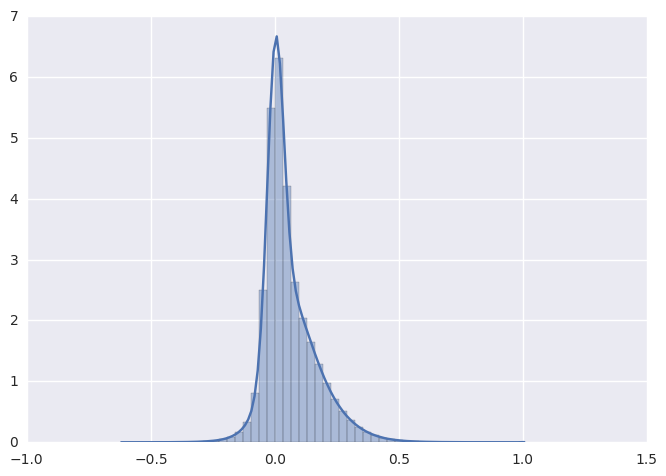

In [6]:
sns.distplot(adj_mat.ravel())

In [21]:
print adj_mat[:5, :5]

[[ 1.          0.19972239  0.11240999  0.06357018  0.27353767]
 [ 0.19972239  1.          0.24668629  0.01336093  0.30280702]
 [ 0.11240999  0.24668629  1.          0.06284576  0.26836507]
 [ 0.06357018  0.01336093  0.06284576  1.          0.07616437]
 [ 0.27353767  0.30280702  0.26836507  0.07616437  1.        ]]


In [22]:
## remove 1's on the diagnal
adj_mat = adj_mat - np.eye(adj_mat.shape[0])
## convert negative values in adj_mat to 0's
adj_mat[adj_mat<0] = 0
print adj_mat[:5, :5]

[[  2.22044605e-16   1.99722389e-01   1.12409986e-01   6.35701792e-02
    2.73537672e-01]
 [  1.99722389e-01   8.88178420e-16   2.46686287e-01   1.33609281e-02
    3.02807020e-01]
 [  1.12409986e-01   2.46686287e-01   2.22044605e-16   6.28457608e-02
    2.68365074e-01]
 [  6.35701792e-02   1.33609281e-02   6.28457608e-02   0.00000000e+00
    7.61643687e-02]
 [  2.73537672e-01   3.02807020e-01   2.68365074e-01   7.61643687e-02
    4.44089210e-16]]


In [23]:
for percent in np.arange(0,100, 5):
    print percent, np.percentile(adj_mat.ravel(), percent)

0 0.0
5 0.0
10

KeyboardInterrupt: 

99.95 0.387579934361
34434 296426


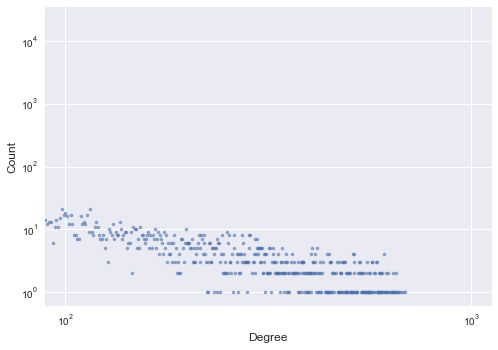

In [34]:
# Create a undirected graph from the adj_mat by first setting values smaller than cutoff to 0's 
# to control number of edges.
percentile_cutoff = 99.95
cosine_similarity_cutoff = np.percentile(adj_mat.ravel(), percentile_cutoff)

print percentile_cutoff, cosine_similarity_cutoff

adj_mat_ = adj_mat.copy()
adj_mat_[adj_mat_<cosine_similarity_cutoff] = 0

G = nx.from_numpy_matrix(adj_mat_)
del adj_mat_

print G.number_of_nodes(), G.number_of_edges()
plot_degree_distribution(G)

In [21]:
## Examine number of large connected components
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        print cc.number_of_nodes()
        print cc.nodes()[:5]

34434
[0, 1, 2, 3, 4]


In [29]:
## Create a new graph only keeping the large connected components
G_new = nx.Graph()
for cc in nx.connected_component_subgraphs(G):
    if cc.number_of_nodes() > 10:
        G_new = nx.compose(G_new, cc)

print G_new.number_of_nodes(), G_new.number_of_edges()

34406 88865


In [30]:
# Relabel nodes with sig_ids
sig_ids_shared = grouped_sorted['sig_id'].tolist()
d_id_sig_id = dict(zip(range(len(sig_ids_shared)), sig_ids_shared))
d_id_sig_id = {nid: sig_id for nid, sig_id in d_id_sig_id.items() if G_new.has_node(nid)}
nx.relabel_nodes(G_new, d_id_sig_id, copy=False)
print G_new.nodes()[:5]

['CPC014_HCC515_6H:BRD-K50168500-001-01-2:10', 'CPC019_PC3_24H:BRD-K30849099-001-07-6:10', 'CPC004_HCC515_6H:BRD-A27554692-001-01-3:10', 'CPC006_NCIH1694_6H:BRD-K17349619-003-01-4:10', 'CPC015_NPC_24H:BRD-A72596465-001-01-3:10']


In [10]:
# nx.write_gexf(G, 'test.gexf')

In [31]:
# nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_%s.gml' % (G_new.number_of_nodes(), percentile_cutoff))
nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_%dnodes_kNN%d.gml' % (G_new.number_of_nodes(), k))